## Model Inspection

#### Imports

In [23]:
import os
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.python.keras.api import keras

from hpcscripts.sharedutils.nomalization import *
from hpcscripts.trainers.windowmanager import WindowGenerator
from hpcscripts.sharedutils.trainingutils import LoadModel, SetLowTFVerbose, MakeSinglePrediction, CreateWindowGenerator, ImportCombinedTrainingData, GetFileList
from hpcscripts.sharedutils.nomalization import DF_Nomalize, denorm
from hpcscripts.sharedutils.modelutils import SelectModelPrompt
from hpcscripts.option import pathhandler as ph
from hpcscripts.option import globalparams as G_PARAMS

### Function Definitions

In [24]:
# Get Training Data to calculate norm param
train_file = os.path.join(ph.GetProcessedPath("Combined"), "Train_set.csv")
train_data, NORM_PARAM = DF_Nomalize(pd.read_csv(train_file))

# Make TensorFlow Quiet
SetLowTFVerbose()

# rad2deg
rad2deg = 180 / math.pi

labels = G_PARAMS.SEQUENTIAL_LABELS

In [39]:
def get_file_list():
    train_dir = ph.GetProcessedPath("Selected")
    test_dir  = ph.GetProcessedPath("Test")

    train_list = os.listdir(train_dir)
    test_list  = os.listdir(test_dir)

    for i, test_file in enumerate (test_list):
        if test_file in train_list:
            train_list.remove(test_file)
        test_list[i] = os.path.join(test_dir, test_file)

    for i, train_file in enumerate (train_list):
        train_list[i] = os.path.join(train_dir, train_file)

    print ("Files found: ")
    print ("\tTrain count: {}".format(len(train_list)))
    print ("\tTest count : {}".format(len(test_list)))

    # Slicing
    print ("\nAfter Slicing: ")
    # train_list = train_list[:3]
    # test_list  = test_list[:3]

    print ("\tTrain count: {}".format(len(train_list)))
    print ("\tTest count : {}".format(len(test_list)))

    return train_list, test_list

In [49]:
def Predict(filename: str, model, window, NORM_PARAM=NORM_PARAM):
    prediction_dict = {}
    file_path = os.path.join (ph.GetProcessedPath("Test"), filename)

    test_df, predictions = MakeSinglePrediction(file_path, model, window)

    for i, label in enumerate(labels):
        z, s = NORM_PARAM[label]
        zt,st= NORM_PARAM["time_s"]

        denormed_time  = denorm(test_df["time_s"].to_numpy(), zt, st)
        denormed_label = denorm(test_df[label], z, s)
        denormed_pred  = denorm(predictions[:, i], z, s)

        if (label.endswith("rad")):
            denormed_pred = denormed_pred * rad2deg
            denormed_label= denormed_label* rad2deg

        prediction_dict[label] = (denormed_label, denormed_pred)
    
    return denormed_time, prediction_dict

def ShowPrediction(filename: str, model, window, NORM_PARAM=NORM_PARAM,
                win_start: int=0, win_end: int=-1,
                a:float = 1, b:float = 0
):
    denormed_time, prediction_dict = Predict(filename, model, window, NORM_PARAM)

    for i, label in enumerate(labels):
        denormed_label, denormed_pred = prediction_dict[label]

        denormed_pred = a*denormed_pred + b

        # plt.plot(denormed_time[win_start:win_end], denormed_label[win_start:win_end])
        plt.scatter(denormed_time[win_start:win_end], denormed_label[win_start:win_end], c='r', marker='X')
        plt.scatter(denormed_time[win_start:win_end], denormed_pred[win_start:win_end], c='b', marker='*')

        print ("timespan: {}".format(denormed_time[-1] - denormed_time[0]))
        print ("mae: {}".format(keras.metrics.mean_absolute_error(denormed_label, denormed_pred)))

        plt.legend(["real", "prediction"])
        plt.xlabel(label.removesuffix("rad")+"deg" if label.endswith("rad") else label)
        plt.show()

def ShowComparison(filename: str, model, window, NORM_PARAM=NORM_PARAM,
                win_start: int=0, win_end: int=-1
):
    denormed_time, prediction_dict = Predict(filename, model, window, NORM_PARAM)

    for i, label in enumerate(labels):
        denormed_label, denormed_pred = prediction_dict[label]

        label_min = float (denormed_label[win_start:win_end].min())
        label_max = float (denormed_label[win_start:win_end].max())
        eq_line = np.linspace(label_min, label_max, denormed_label[win_start:win_end].shape[0])

        # plt.plot(denormed_time[win_start:win_end], denormed_label[win_start:win_end])
        plt.scatter(denormed_label[win_start:win_end], denormed_pred[win_start:win_end], c='r', marker='X')
        plt.plot(eq_line, eq_line)

        print ("timespan: {}".format(denormed_time[-1] - denormed_time[0]))
        print ("mae: {}".format(keras.metrics.mean_absolute_error(denormed_label, denormed_pred)))

        plt.legend(["real", "prediction"])
        plt.xlabel(label.removesuffix("rad")+"deg" if label.endswith("rad") else label)
        plt.show()

In [27]:
def PredictFore():
    pass

## Importing Model

In [28]:
model_dir = ph.GetModelsPath()
model_dir = SelectModelPrompt(model_dir)

print ()
model, model_history, modelsmeta = LoadModel(model_dir)

G_PARAMS.SetParams(modelsmeta['param'])

epochs = [a+1 for a in range(len(model_history['loss']))]
print ("\nmodel_id: {}".format(modelsmeta['model_id']))
print ("model_history keys: {}".format(model_history.keys()))
print ("modelsmeta: {}".format(modelsmeta))

Found 7 models inside /home/ikhwansh/Datas/Cool Yeah/TeA/HPC_Scripts/Data/Models:
index    Model-name
  [0].   AA_elev_5_feat_1
  [1].   AA_elev_5_feat_20
  [2].   Baseline
  [3].   Conv
  [4].   Dense
  [5].   GRU
  [6].   LSTM
You selected model AA_elev_5_feat_20


model loaded
model history loaded
model metadata loaded

model_id: best_e_min_20
model_history keys: dict_keys(['loss', 'mean_squared_error', 'mean_absolute_error', 'val_loss', 'val_mean_squared_error', 'val_mean_absolute_error'])
modelsmeta: {'model_id': 'best_e_min_20', 'param': (20, 1, 0, [4, 16], ['hralt_m', 'hdot_1_mps', 'theta_rad', 'cas_mps', 'gamma_error_rad'], ['elv_l_rad', 'N1s_rpm'], None)}


In [29]:
model_history['val_mean_absolute_error']

[0.4883982241153717,
 0.4718816876411438,
 0.47202566266059875,
 0.46622154116630554,
 0.46211549639701843,
 0.46289363503456116,
 0.4581988453865051]

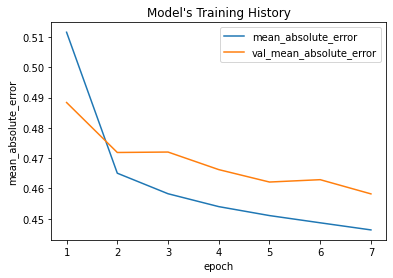

In [30]:
metric = 'mean_absolute_error'
plt.plot(epochs, model_history[metric])
plt.plot(epochs, model_history['val_{}'.format(metric)])

plt.xlabel("epoch")
plt.ylabel(metric)
plt.title("Model's Training History")
plt.legend([metric, 'val_{}'.format(metric)])
plt.show()

In [31]:
_z, _s = NORM_PARAM['elv_l_rad']
last_val_MAE = model_history['val_mean_absolute_error'][-1]

print ("denormed MAE: {}".format(denorm(last_val_MAE, _z, _s)))
print ("denormed MAE: {}".format(denorm(0.0000, _z, _s)))

elv_MAE = denorm(last_val_MAE, _z, _s)-denorm(0.0000, _z, _s)
elv_MAE = elv_MAE*180/math.pi 
print ("MAE: {} deg".format(elv_MAE))


denormed MAE: -0.06268824957553841
denormed MAE: -0.0813096731433771
MAE: 1.0669289789626004 deg


## Making Few Predictions

In [40]:
train_list, test_list = get_file_list()

pred_window = CreateWindowGenerator(
                    train_list=test_list,
                    test_list=None, eval_list=None,
                    norm_param=NORM_PARAM
                )

Files found: 
	Train count: 395
	Test count : 73

After Slicing: 
	Train count: 395
	Test count : 73


In [41]:
filename = test_list[0]
os.path.basename(filename)

'flight_39605.csv'

In [42]:
if False:
    _flightname = "flight_33375.csv" # "flight_14196.csv"
    _win_start = 0#150
    _win_end = -1 #200

    ShowPrediction( 
                _flightname,# "flight_10301.csv",
                model=model,
                window=pred_window,
                win_start=_win_start,
                win_end=_win_end
            )

    print ("COMPARISON")
    ShowComparison( 
                _flightname,# "flight_10301.csv",
                model=model,
                window=pred_window,
                win_start=_win_start,
                win_end=_win_end
            )

## R2 Results

In [43]:
# Check r2 results
r2csv_path = os.path.join(model_dir, "r2.csv")
if not os.path.exists(r2csv_path):
    exit()

r2_df = pd.read_csv(r2csv_path)

r2_df.describe()
#r2_df.head()

,r2_elv_l_rad,mae_elv_l_rad,mae_elv_l_deg,mse_elv_l_rad,r2_N1s_rpm,mae_N1s_rpm,mse_N1s_rpm
count,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000
mean,-8.909932,0.028870,1.654143,0.002306,0.715406,3.119246,17.653826
std,28.434904,0.037503,2.148763,0.006418,0.549861,0.838041,9.805263
min,-142.512745,0.005073,0.290663,0.000042,-3.574541,1.441794,2.973887
25%,-3.853806,0.008667,0.496579,0.000125,0.671646,2.507653,11.052435
50%,0.004734,0.015518,0.889102,0.000332,0.816285,3.018754,15.065490
75%,0.404100,0.031351,1.796258,0.001130,0.902577,3.589434,21.377768
max,0.829829,0.172656,9.892481,0.029846,0.966415,5.386245,54.738239


In [44]:
if False:
    bellow_zero = r2_df.loc[r2_df["r2_elv_l_rad"] <= 0].shape[0]
    print ("bellow zero: {}".format(bellow_zero))
    print ("percent bellow zero: {}%".format(100*bellow_zero/r2_df.shape[0]))

In [45]:
if False:
    best_330 = r2_df.nlargest(330, columns=["r2_elv_l_rad"]).iloc[:, 0].to_list()

    import os
    import shutil

    target_dir = ph.GetProcessedPath(dir="Best330")
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)

    for file in os.listdir(ph.GetProcessedPath(dir="Selected")):
        if file in best_330:
            shutil.copy(
                os.path.join(ph.GetProcessedPath(dir="Selected"), file),
                os.path.join(target_dir, file)
            )



In [46]:
r2_df.nlargest(8, columns=["r2_elv_l_rad"])
#r2_df.nlargest(8, columns=["r2_ail_lr_rad"])

,filename,r2_elv_l_rad,mae_elv_l_rad,mae_elv_l_deg,mse_elv_l_rad,r2_N1s_rpm,mae_N1s_rpm,mse_N1s_rpm
27,flight_14050.csv,0.829829,0.007168,0.410720,0.000083,0.931930,2.495905,9.207434
54,flight_17911.csv,0.778976,0.008814,0.505030,0.000128,0.911812,2.224661,8.152418
42,flight_19154.csv,0.664596,0.008534,0.488959,0.000119,0.932237,2.438428,10.477391
64,flight_14196.csv,0.664453,0.008159,0.467481,0.000125,0.807390,2.507653,9.424747
31,flight_10176.csv,0.659752,0.008066,0.462156,0.000125,0.916324,2.370885,9.435553
26,flight_31089.csv,0.632350,0.007347,0.420961,0.000094,0.896499,2.373940,11.939369
39,flight_17399.csv,0.624391,0.007036,0.403150,0.000094,0.788181,2.891641,13.142196
8,flight_36729.csv,0.617174,0.009604,0.550282,0.000173,0.783582,4.599394,36.480549


In [47]:
# r2_df.loc[r2_df.iloc[:, 1] < 0]
r2_df.nsmallest(10, columns=["r2_elv_l_rad"])
#r2_df.nsmallest(10, columns=["r2_ail_lr_rad"])

,filename,r2_elv_l_rad,mae_elv_l_rad,mae_elv_l_deg,mse_elv_l_rad,r2_N1s_rpm,mae_N1s_rpm,mse_N1s_rpm
65,flight_35905.csv,-142.512745,0.162750,9.324887,0.026555,0.924189,2.792095,13.651887
63,flight_35911.csv,-141.972977,0.170309,9.758012,0.029089,0.886881,3.367012,17.368589
3,flight_35819.csv,-95.137108,0.157658,9.033121,0.024892,0.654173,4.423295,54.738239
37,flight_36060.csv,-94.582139,0.172656,9.892481,0.029846,0.902577,2.539534,11.517975
48,flight_24824.csv,-22.117631,0.059804,3.426525,0.003642,-3.574541,4.881894,31.060936
41,flight_17181.csv,-20.143435,0.068437,3.921163,0.004926,0.593110,3.705356,23.730619
20,flight_32685.csv,-19.000871,0.063560,3.641697,0.004087,0.819265,2.632059,11.052435
60,flight_16574.csv,-18.056221,0.053670,3.075043,0.003020,0.898592,3.018754,14.840063
17,flight_15886.csv,-10.712818,0.043648,2.500871,0.002027,0.736053,3.878675,23.770802
38,flight_32355.csv,-6.653075,0.045014,2.579117,0.002075,0.803372,2.761246,12.775936


filename: rec_33.csv
timespan: 163.79999999999927
mae: 0.8853124380111694


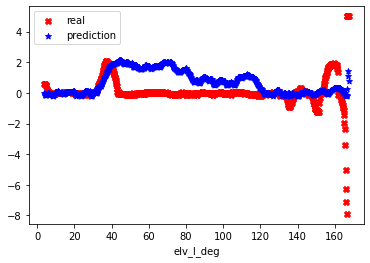

timespan: 163.79999999999927
mae: 92.77113342285156


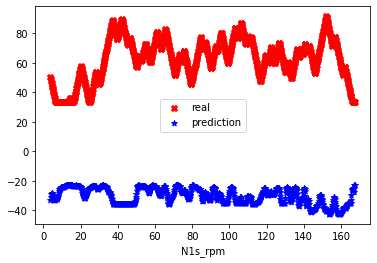

In [60]:
filename_to_predict = "rec_33.csv"
print ("filename: {}".format(filename_to_predict))
ShowPrediction(filename_to_predict, model, window=pred_window, a=-0.6, b=-2.6)

### Make Predictions

#### Func Definition

In [40]:
def PlotManyPredictions(filelist, r: int = 2):
    fig = plt.figure(constrained_layout=True)

    label_count = len(G_PARAMS.SEQUENTIAL_LABELS)
    rows = r
    cols = 4

    gs = fig.add_gridspec(rows*label_count, cols)

    i = 0
    for j in range(cols):
        for i in range(rows):
            flightname = filelist[i*cols + j]
            denormed_time, prediction_dict = Predict(
                                                filename=flightname,
                                                model=model,
                                                window=pred_window,
                                                NORM_PARAM=NORM_PARAM
                                            )

            # Plot every labels for one flight
            for sr in range(label_count):
                label_index = sr
                label = G_PARAMS.SEQUENTIAL_LABELS[label_index]

                denormed_label, denormed_pred = prediction_dict[label]

                ax = fig.add_subplot(gs[i*label_count + sr, j])
                ax.plot (denormed_time, denormed_label)
                ax.plot (denormed_time, denormed_pred)
                ax.grid()

                if label_index == 0:
                    ax.set_title(flightname)
                if label_index == label_count-1:
                    ax.set_xlabel("Time (s)")

                if j == 0 or j == 2:
                    ax.set_ylabel('\n'*j + label)
                if j == 1 or j == 3:
                    ax.legend(["real", "prediction"])

    fig.set_size_inches(18/4*cols, 3*rows)
    fig.suptitle("Prediction Samples\n")
    fig.show()

In [41]:
def plot_best_and_worst(metric_label = ["r2_elv_l_rad"]):
    best_list = list(r2_df.nlargest(10, columns=metric_label).iloc[:2, 0])
    worst_list = list(r2_df.nsmallest(10, columns=metric_label).iloc[:2, 0])
    flight_list = best_list + worst_list

    important_title = ["Best 1", "Best 2", "Worse 1", "Worse 2"]

    fig = plt.figure(constrained_layout=True)

    rows = len(G_PARAMS.SEQUENTIAL_LABELS)
    cols = 4

    gs = fig.add_gridspec(rows, cols)

    for j in range(cols):
        big_title = important_title[j]
        flightname = flight_list[j]
        denormed_time, prediction_dict = Predict(
                                            filename=flightname,
                                            model=model,
                                            window=pred_window,
                                            NORM_PARAM=NORM_PARAM
                                        )
        
        for i in range(rows):
            label_index = i % rows
            label = G_PARAMS.SEQUENTIAL_LABELS[label_index]

            denormed_label, denormed_pred = prediction_dict[label]

            ax = fig.add_subplot(gs[i, j])
            ax.plot (denormed_time, denormed_label)
            ax.plot (denormed_time, denormed_pred)
            ax.grid()

            if label_index == 0:
                ax.set_title(big_title)
            if label_index == rows-1:
                ax.set_xlabel("Time (s)" + "\n" + flightname)

            if j == 0 or j == 2:
                ax.set_ylabel('\n'*j + label)
            if j == 1 or j == 3:
                ax.legend(["real", "prediction"])

    fig.set_size_inches(18/4*cols, 3*rows)
    fig.suptitle("Best and Worst Prediction\n")
    fig.show()


#### Prediction Summary

2022-09-16 05:58:22.687588: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
/tmp/ipykernel_3486/2628410547.py:48: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


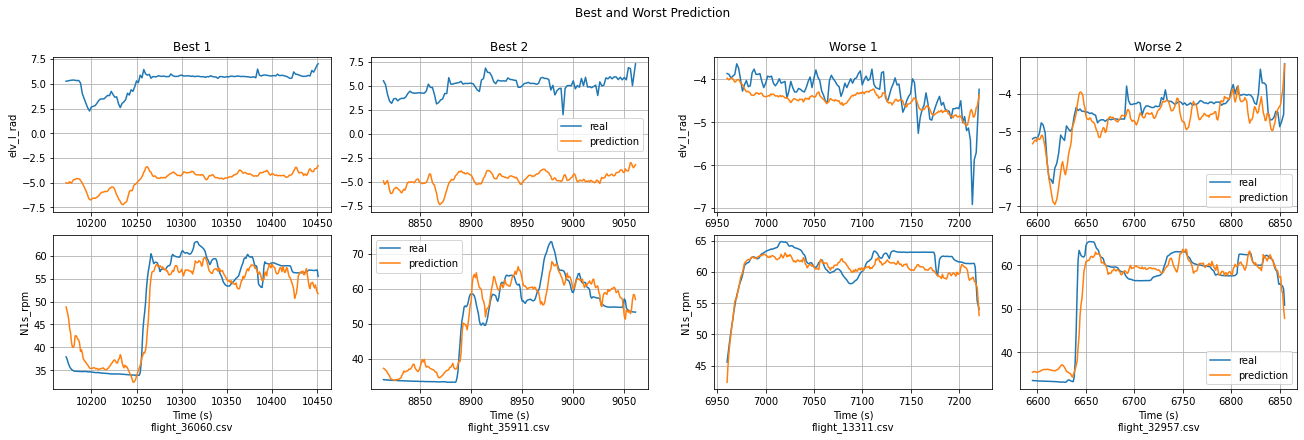

In [42]:
metric_label = ["r2_elv_l_rad"]
# metric_label = ["r2_N1s_rpm"]
metric_label = ["mae_elv_l_deg"]
#metric_label = ["mae_ail_lr_deg"]

plot_best_and_worst(metric_label)

/tmp/ipykernel_3486/4126840474.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


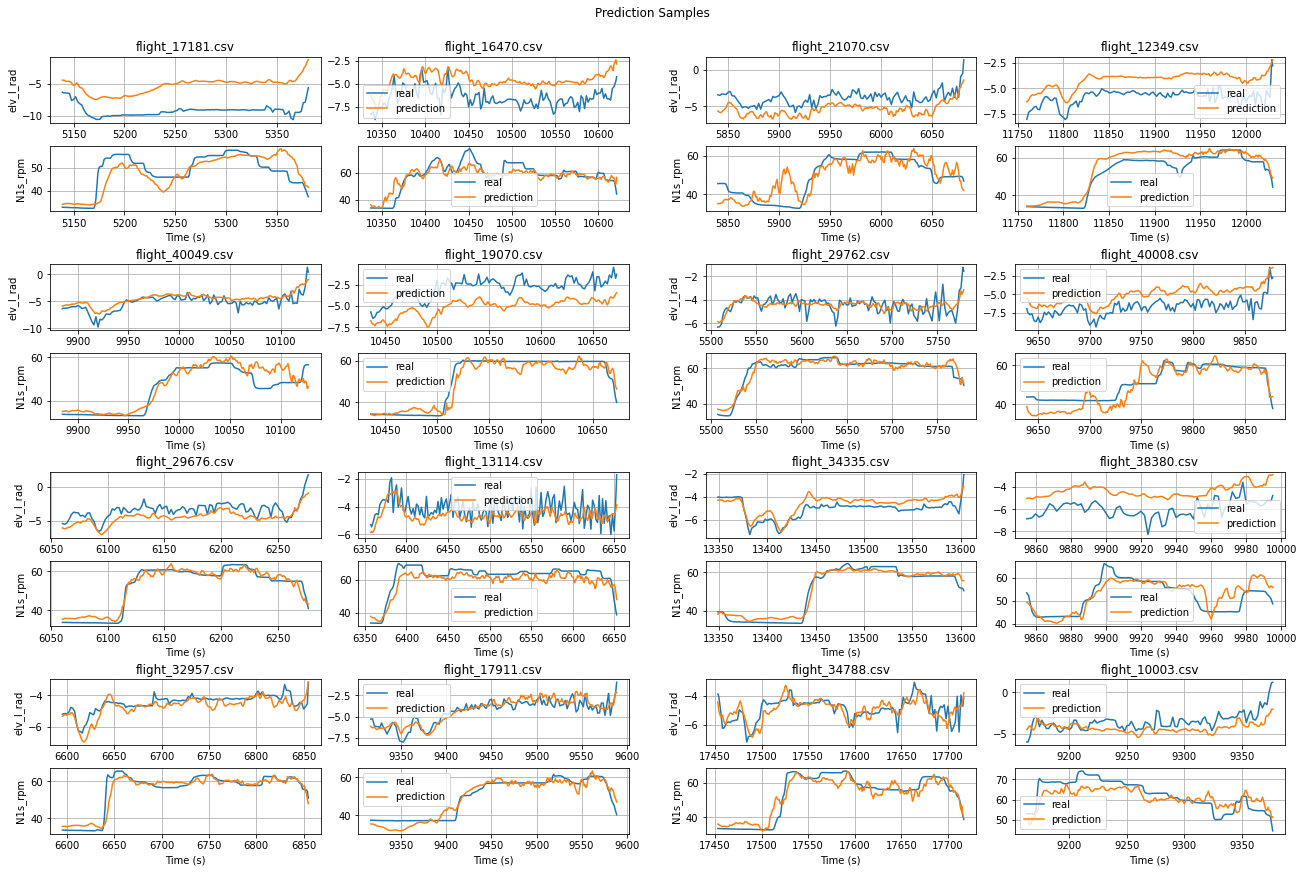

In [43]:
row = 4
col = 4

n = row*col
filelist = list(r2_df.sample(n).iloc[:, 0])

PlotManyPredictions(filelist, r=row)

In [44]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 4)                 404       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                80        
_________________________________________________________________
dense_for_reshaping (Dense)  (None, 2)                 34        
_________________________________________________________________
reshape (Reshape)            (None, 1, 2)              0         
Total params: 518
Trainable params: 518
Non-trainable params: 0
_________________________________________________________________


In [45]:
for i, layer in enumerate(model.layers):
    if isinstance(layer, tf.keras.layers.Dropout):
        print ("layer {}, rate: {}".format(i, layer.rate))

In [46]:
# Import Data
train_comb= ImportCombinedTrainingData()

# Pre-process Data
train_comb, norm_param = DF_Nomalize(train_comb)
train_list, test_list, eval_list = GetFileList()

# Create WindowGenerator
windowG = CreateWindowGenerator(train_list, 
                test_list, eval_list, norm_param)

model.evaluate(windowG.test)

543/543 [==============================] - 5s 7ms/step - loss: 0.7619 - mean_squared_error: 0.7619 - mean_absolute_error: 0.4889


[0.761854350566864, 0.761854350566864, 0.4888836741447449]

In [47]:
file_path = os.path.join (ph.GetProcessedPath("Selected"), "flight_10930.csv")

ds = windowG.make_dataset([file_path], batch_size=None)
features, labels = next(iter(ds))

predictions = model.predict(features)
print ('features:')

shape = features[0].shape
for i in range (shape[0]):
    for j in range (shape[1]):
        print (float(features[0][i][j]), end=', ')
    print (';')
print ('predictions: \n{}'.format(predictions[0]))

features:
0.8449851464023104, 1.0861874647349428, -0.7392993457335791, -0.5068827418732214, -0.6024632745358292, ;
0.8212008789866535, 0.692432162858012, -0.7210437642495735, -0.5728396544430877, -0.437048877398229, ;
0.8350750349791201, 0.6268062792118569, -0.6541048712775498, -0.6116378383077149, -0.20398521773506317, ;
0.862823346964053, 0.16742509368877131, -0.5628237943023134, -0.6465562037858792, 0.058943396863860756, ;
0.8707514361026053, 0.3643027446272367, -0.43503155435906926, -0.6581956589452672, 0.239804252847845, ;
0.8766975029565195, 0.5611803955657021, -0.3194093498990267, -0.6775947508775805, 0.36042444664534046, ;
0.8786795252411576, 0.10179921004261619, -0.21595823744058892, -0.6853543876505056, 0.43569565280360845, ;
0.8786795252411576, 0.03617332639646106, -0.13684825246696022, -0.7280323899015958, 0.4696974409695566, ;
0.8489491909715865, -0.029452557249694082, -0.057738267493331726, -0.7435516634474468, 0.4726874766251615, ;
0.8251649235559296, -0.2919560918343146

In [48]:
# print (windowG.norm_param)
features_columns = [
            'hralt_m', 'hdot_1_mps', 'theta_rad', 'cas_mps', 
            'gamma_error_rad', 'tailwind_mps', 'g_err_d_rad',
] # ['hralt_m', 'theta_rad', 'cas_mps', 'hdot_1_mps', 'gamma_error_rad', 'elv_l_rad', 'N1s_rpm']

#features_columns = [
#            'phi_rad'
#] # ['hralt_m', 'theta_rad', 'cas_mps', 'hdot_1_mps', 'gamma_error_rad', 'elv_l_rad', 'N1s_rpm']

norm_param_df = pd.DataFrame(windowG.norm_param)
norm_param_df.to_csv('norm_param.csv')

# means
for feature in features_columns:
    print (norm_param[feature][0], end=' ')
print ()

# std
for feature in features_columns:
    print (norm_param[feature][1], end=' ')
print ()

244.6554175210584 -3.621121956273188 -0.046883198749524964 67.70178292347225 0.0003672945025212604 2.1475720067250124 -6.549130277065433e-05 
153.78232745534365 1.2385357039647575 0.031508706143831645 8.287114704179217 0.014092728462689602 3.9312489967548654 0.002798829343444247 


In [49]:
labels_columns = [
            'elv_l_rad', 'N1s_rpm'# 'ail_lr_rad'
] # ['hralt_m', 'theta_rad', 'cas_mps', 'hdot_1_mps', 'gamma_error_rad', 'elv_l_rad', 'N1s_rpm']

# means
for label in labels_columns:
    print (norm_param[label][0], end=' ')
print ()

# std
for label in labels_columns:
    print (norm_param[label][1], end=' ')
print ()

-0.0813096731433771 51.91470945528152 
0.04064048557811387 10.99333912164685 


In [81]:
file_path = os.path.join (ph.GetProcessedPath("Selected"), "flight_10930.csv")
df = pd.read_csv(file_path)

features_columns = [
            'hralt_m', 'hdot_1_mps', 'theta_rad', 'cas_mps', 
            'gamma_error_rad', 'tailwind_mps', 'g_err_d_rad', 'elv_l_rad', 'N1s_rpm', 'phi_rad', 'ail_lr_rad'
] # ['hralt_m', 'theta_rad', 'cas_mps', 'hdot_1_mps', 'gamma_error_rad', 'elv_l_rad', 'N1s_rpm']

newdf = df.iloc[0:9, :].loc[:, features_columns ]
# newdf.to_csv("cut_flight_10930.csv", index=False)


for feature in features_columns:
    tosave_df = df.loc[:, feature ].to_frame()
    tosave_df.rename(columns={feature:'f (t)'}, inplace=True)
    tosave_df.index.name = 't (s)'
    tosave_df.to_csv('{}.csv'.format(feature), header=False)

newdf

,hralt_m,hdot_1_mps,theta_rad,cas_mps,gamma_error_rad,tailwind_mps,g_err_d_rad,elv_l_rad,N1s_rpm,phi_rad,ail_lr_rad
0,374.5992,-2.27584,-0.070178,63.501188,-0.008123,2.952147,-0.001441,-0.050916,52.953125,0.032021,1.466925
1,370.9416,-2.76352,-0.069602,62.954595,-0.005792,2.226303,0.002331,-0.053951,52.984375,0.024351,1.467015
2,373.0752,-2.84480,-0.067493,62.633070,-0.002507,2.049930,0.003285,-0.052523,52.945312,0.014572,1.447823
3,377.3424,-3.41376,-0.064617,62.343697,0.001198,2.114057,0.003705,-0.051095,52.968750,0.005561,1.428631
4,378.5616,-3.16992,-0.060590,62.247240,0.003747,2.134286,0.002549,-0.050381,52.945312,-0.002301,1.423721
5,379.4760,-2.92608,-0.056947,62.086478,0.005447,1.846874,0.001700,-0.049667,52.968750,-0.009779,1.418812
6,379.7808,-3.49504,-0.053688,62.022173,0.006507,1.631097,0.001061,-0.047703,52.929688,-0.012847,1.414348
7,379.7808,-3.57632,-0.051195,61.668495,0.006987,1.700699,0.000479,-0.045739,52.945312,-0.010546,1.409885
8,375.2088,-3.65760,-0.048702,61.539885,0.007029,1.481923,0.000042,-0.045917,52.953125,-0.002684,1.415598


In [ ]:
np.set_printoptions(precision=4, suppress=True)
labels_list = []
for i in range(newdf.shape[0] - 6 + 1):
    print ("i = {}".format(i))

    print ("feature_{}".format(i))
    print (newdf.iloc[i:(i+5), :5].to_numpy())

    labels_list.append(
        newdf.iloc[i+5, -2:].to_numpy().tolist()
    )

print ("Labels: \n{}".format(np.array(labels_list)))

i = 0
feature_0
[[374.5992  -0.0702  63.5012  -2.2758  -0.0081]
 [370.9416  -0.0696  62.9546  -2.7635  -0.0058]
 [373.0752  -0.0675  62.6331  -2.8448  -0.0025]
 [377.3424  -0.0646  62.3437  -3.4138   0.0012]
 [378.5616  -0.0606  62.2472  -3.1699   0.0037]]
i = 1
feature_1
[[370.9416  -0.0696  62.9546  -2.7635  -0.0058]
 [373.0752  -0.0675  62.6331  -2.8448  -0.0025]
 [377.3424  -0.0646  62.3437  -3.4138   0.0012]
 [378.5616  -0.0606  62.2472  -3.1699   0.0037]
 [379.476   -0.0569  62.0865  -2.9261   0.0054]]
i = 2
feature_2
[[373.0752  -0.0675  62.6331  -2.8448  -0.0025]
 [377.3424  -0.0646  62.3437  -3.4138   0.0012]
 [378.5616  -0.0606  62.2472  -3.1699   0.0037]
 [379.476   -0.0569  62.0865  -2.9261   0.0054]
 [379.7808  -0.0537  62.0222  -3.495    0.0065]]
i = 3
feature_3
[[377.3424  -0.0646  62.3437  -3.4138   0.0012]
 [378.5616  -0.0606  62.2472  -3.1699   0.0037]
 [379.476   -0.0569  62.0865  -2.9261   0.0054]
 [379.7808  -0.0537  62.0222  -3.495    0.0065]
 [379.7808  -0.0512  

In [ ]:
file_path = os.path.join (ph.GetProcessedPath("Raw"), "flight_10930.csv")
df = pd.read_csv(file_path)

#newdf = df.iloc[0:9, :].loc[:, ['hralt_m', 'theta_rad', 'cas_mps', 'hdot_1_mps', 'gamma_error_rad', 'elv_l_rad', 'N1s_rpm'] ]
#newdf.to_csv("cut_flight_10930.csv", index=False)
#newdf

plt.scatter (df['time_s'], df['hralt_m'], marker='X')

freq = int (1/0.125)

divider = int (freq / .5)
i_list = [a*divider for a in range(int(df.shape[0]/divider))]
df = df.iloc[i_list, :]
df.reset_index(drop=True, inplace=True)

In [ ]:
#
# plt.style.use('science')

split_range = slice(530/2, 560/2)

with plt.style.context(['science', 'ieee']):
    plt.scatter (df.loc[split_range, 'time_s'], df.loc[split_range, 'elv_l_rad'] * 180/math.pi, marker='x')
    plt.xlabel('time (s)')
    plt.ylabel('Elevator Deflection (deg)')
    plt.ylim((-45, 20))

In [ ]:
new_df = df.copy()
new_df.loc[new_df['elv_l_rad'] < -20*math.pi/180] = np.nan
new_df = new_df.interpolate()

with plt.style.context(['science', 'ieee']):
    plt.scatter (new_df.loc[split_range, 'time_s'], new_df.loc[split_range, 'elv_l_rad'] * 180/math.pi, marker='x')
    plt.xlabel('time (s)')
    plt.ylabel('Elevator Deflection (deg)')
    plt.ylim((-45, 20))

In [ ]:
df.loc[df['elv_l_rad'] < -20*math.pi/180].loc[:, ['time_s', 'elv_l_rad']]

In [ ]:
-0.731293*180/math.pi

In [ ]:
with plt.style.context(['science', 'ieee']):
    plt.plot (df.loc[:, 'time_s'], df.loc[:, 'hralt_m'])
    plt.xlabel('time (s)')
    plt.ylabel('Altitude (m)')
    # plt.ylim((-45, 20))

In [ ]:
file_path = os.path.join (ph.GetProcessedPath("Selected"), "flight_10930.csv")
sam_df = pd.read_csv(file_path)

with plt.style.context(['science', 'ieee']):
    plt.plot (sam_df.loc[:, 'time_s'], sam_df.loc[:, 'hralt_m'])
    plt.xlabel('time (s)')
    plt.ylabel('Altitude (m)')